<a href="https://colab.research.google.com/github/nahuelalmeira/redesNeuronales/blob/master/practico1/Practico1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Práctico 1**

El sistema de dos ecuaciones diferenciales ordinarias definido como:

\begin{cases}
\dot{C} &= \alpha C - \beta C Z \\
\dot{Z} &= -\gamma Z + \delta C Z
\end{cases}

es conocido como **Modelo de predadores y presas de Lokta-Volterra**. La función $C(t)$ modela el número de conejos en un ecosistema dado, y $Z(t)$ la cantidad de zorros en el mismo ecosistema.

a) Construí el diagrama de flujo con las herramientas teóricas presentadas en el curso para el caso particular en que los parámetros toman los siguientes valores:

$$
\alpha = 0.1\quad
\beta = 0.02\quad
\gamma = 0.3\quad
\delta = 0.01
$$

b) Reflexioná sobre los significados biológicos de cada uno de los términos y coeficientes $\alpha$, $\beta$, $\gamma$ y $\delta$ de las ecuaciones. Construí y analizá biológicamente el diagrama de fase.

c) Encontrá una solución numérica aproximada al problema para el caso particular en que los parámetros toman los siguientes valores del punto a) entre $t= 0$ y $t = 200$, para un paso de integración $h = 0.05$ y para las condiciones iniciales

$$
C(0) = 40\quad \mathrm{y} \quad Z(0) = 9.
$$

Recordá que esto se denomina **problema de valor inicial**.

d) Graficá, con los resultados del punto anterior, $C(t)$ vs. $Z(t)$ en un mismo gráfico (gráfico paramétrico), entre $t=0$ y $t=200$ y comentá los resultados.

## **Solución**

### **Equilibrios**

Los equilibrios, o puntos fijos, del sistema, se definen como los puntos $(C^*,Z^*)$ tales que $\dot{C} = \dot{Z} = 0$.

Por inspección, podemos ver fácilmente que $P_1 := (0,0)^T$ es un punto fijo. Para determinar si existen más equilibrios, supongamos $C^* \neq 0$. Luego, de la primera ecuación del sistema se deduce que $Z^* = \beta / \alpha$. Dado que los parámetros del sistema son todos positivos, deducimos entonces de la segunda ecuación que $C^* = \gamma / \delta$. Es decir, $P_2:= (\gamma/\delta, \alpha/\beta)^T$ es punto fijo.

### **Estabilidad**

Linealizamos el sistema. Para ello, calculamos la matriz jacobiana

$$
A =
\begin{bmatrix}
\alpha - \beta Z & -\beta C \\
\delta Z & -\gamma + \delta C
\end{bmatrix}
$$

#### Equilibrio $P_1 = (0,0)^T$

$$
A =
\begin{bmatrix}
\alpha & 0 \\
0 & -\gamma
\end{bmatrix}
$$

La matriz jacobiana es diagonal, y sus autovalores son $\lambda_1 = \alpha > 0$ y $\lambda_2 = -\gamma < 0$. Es decir, se trata de un punto saddle. Los autovectores correspondientes son $v_1 = (1, 0)$, correspondiente a la dirección estable, y $v_2 = (0, 1)$, correspondiente a la dirección inestable. 

#### Equilibrio $P_2:= (\gamma/\delta, \alpha/\beta)^T$

$$
A =
\begin{bmatrix}
0 & -\dfrac{\beta \gamma}{\delta} \\
\dfrac{\alpha \delta}{\beta} & 0
\end{bmatrix}
$$

Diagonalizando obtenemos el polinomio característico

$$
\lambda^2 + \alpha \gamma = 0.
$$

Luego, los autovalores son imaginarios puros de la forma $\lambda_{\pm} = i \omega_{\pm}$, con $\omega_{\pm} = \pm \sqrt{\alpha \gamma}$. El hecho de que los autovalores tengan una componente imaginaria indica que las trayectorias cercanas al punto fijo oscilan en torno al mismo. Sin embargo, como la parte real es nula, el criterio no permite determinar la estabilidad del mismo.


#### Nullclinas

Partiendo de las ecuaciones, podemos ver que las nullclinas están descriptas por las curvas

$$
\begin{align}
\dot{C} &= 0\quad  \Rightarrow \quad C = 0 \quad \mathrm{\wedge}\quad Z = \alpha / \beta \\
\dot{Z} &= 0\quad  \Rightarrow \quad Z = 0 \quad \mathrm{\wedge}\quad C = \gamma / \delta 
\end{align}
$$

Además, observando los signos de las derivadas no nulas sobre las nullclinas, podemos determinar que el flujo oscila en torno al equilibrio $E_2$ en dirección antihoraria.

#### Adimensionalización

Para continuar analizando el sistema, conviene adimensionalizar las ecuaciones. Para ello, definimos constantes $a$, $b$, $c$, $d$ y $\tau$, y nuevas variables $x$ e $y$ tales que

$$
x(t) = \dfrac{\delta C(t)}{\gamma}, \quad y(t) = \dfrac{\beta Z(t)}{\alpha}, \quad \tau = \alpha t, \quad r = \gamma / \alpha.
$$

Con estas definiciones, podemos reescribir nuestro sistema como 

$$
\begin{cases}
\dot{x} &= x (1-y) \\
\dot{y} &= ry (x-1).
\end{cases}
$$

En el plano de fases adimensionalizado $xy$, las trayectorias están descriptas por las soluciones a la ecuación diferencial

$$
\dfrac{dy}{dx} = r\dfrac{y(x-1)}{x(1-y)}.
$$

Integrando esta ecuación, obtenemos

$$
rx + y - \ln x^r y = E,
$$

con $E = \mathrm{cte}$.
Es decir, el sistema es conservativo y $E$ es la "energía", o cantidad conservada, del sistema. Además, podemos ver que el punto $P_2$, que en las nuevas coordenadas es $P_2 = (1,1)$, es un mínimo de la energía. Sabiendo esto, podemos aplicar un teorema (Teorema 6.5.1, Strogatz), que dice que cualquier trayectoria cercana a $P_2$ es una curva cerrada. En otras palabras, $P_2$ es un centro.

In [1]:
## Importamos paquetes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp

%matplotlib inline


## Parámetros para graficar
sns.set_style('darkgrid')
sns.set_context('talk')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

BLUE = '#1f77b4'
ORANGE = '#ff7f0e'
GREEN = '#2ca02c'
PURPLE = '#9467bd'

**a)**

Definimos funciones auxiliares

In [2]:
def FoxesVsRabbits(t, y, *args):
    """
    Sistema de tipo Lokta-Volterra, con interacción de dos
    especies competidoras: conejos (r) y ovejas (s).
    """
    c, z = y
    alpha, beta, gamma, delta = args

    dcdt = alpha*c - beta*c*z
    dzdt = -gamma*z + delta*c*z

    dydt = (dcdt, dzdt)

    return dydt

def energia(y, *args):
    """
    Calcula la energia del sistema
    """
    c, z = y
    alpha, beta, gamma, delta = args
    
    r = gamma / alpha
    x = delta * c / gamma
    y = beta * z / alpha
    
    E = r*x + y - np.log(x**r * y)
    
    return E

Definimos los valores de parámetros

In [3]:
alpha = 0.1
beta  = 0.02
gamma = 0.3
delta = 0.01
args = (alpha, beta, gamma, delta)

Construimos el diagrama de flujos

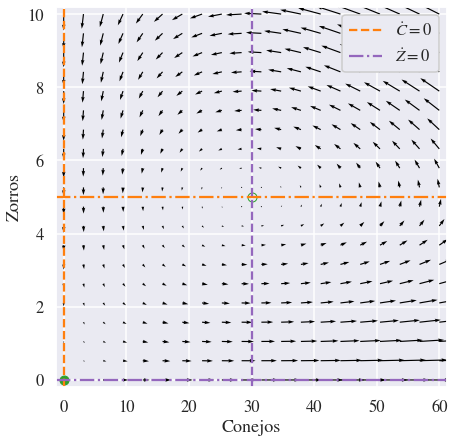

In [21]:
## Creamos una grilla en el espacio de fases,
## representada por las variables R y S
c_values = np.linspace(0,2*gamma/delta,20)
z_values = np.linspace(0,2*alpha/beta,20)
C, Z = np.meshgrid(c_values, z_values)

## En cada punto de la grilla graficamos una flecha. Las variables
## U y V representan las coordenadas de las flechas 
U, V = FoxesVsRabbits(None, [C, Z], *args)

## Realizamos el gráfico
fig, ax = plt.subplots(figsize=(7,7))
ax.set_ylabel('Zorros')
ax.set_xlabel('Conejos')

## Graficamos el campo de pendientes
ax.quiver(C, Z, U, V)

## Punto fijo intestable
ax.plot(gamma/delta, alpha/beta, 'o', fillstyle='none', color=GREEN)

## Punto fijo estable
ax.plot(0, 0, 'o', color=GREEN)

## Nullclinas
ax.axvline(0, color=ORANGE, linestyle='--', label=r'$\dot{C} = 0$')
ax.axhline(alpha/beta, linestyle='-.', color=ORANGE)
ax.axhline(0, color=PURPLE, linestyle='-.', label=r'$\dot{Z} = 0$')
ax.axvline(gamma/delta, linestyle='--', color=PURPLE)
   
ax.margins(0.02)
#ax.legend(loc=(1.01, 0.9))
ax.legend(loc='upper right', framealpha=1)

plt.savefig('flujo.pdf')
plt.show()

**b)**

Interpretación biológica de los parámetros:

Para interpretar biológicamente los parámetros conviene pensar qué pasaría si cada una de las especies estuviera aislada. En ese caso, tendríamos las siguientes dos ecuaciones no acopladas

$$
\dot{C} = \alpha C, \quad \dot{Z} = - \gamma Z.
$$

Las soluciones a estas ecuaciones son exponenciales. En el caso de los Conejos, la población crece exponencialmente, mientras que en el caso de los Zorros decrece, tendiendo a la extinción. CUando una población presenta una variación lineal, como en este caso, la interpretación más simple es considerar que esta variación se debe a una competencia entre el número de nacimientos y el número de muertes. Podríamos pensar entonces que $\alpha = \alpha_N - \alpha_M$, y que $-\gamma = \gamma_N - \gamma_M$, donde los subíndices $N$ y $M$ representan "nacimientos" y "muertes". Para los Conejos, la tasa de nacimientos supera a la tasa de mortalidad, por lo que el balance da positivo. En cambio, la mortalidad de los Zorros supera a los nacimientos, por lo que el balance da negativo. 

Los parámetros $\beta$ y $\delta$ son propios de la relación interespecífica en cuestión. El primero nos indica la magnitud en la que decrece la cantidad de Conejos como producto de la interacción con los Zorros (al ser depredados por ellos). El segundo nos indica, de forma análoga, en qué medida se incrementa la cantidad de Zorros al depredar a su presa. Es de esperar que $\beta > \delta$ ya que, al ser los Zorros una especie más grande que los Conejos en términos de biomasa, para incrementar en una unidad la cantidad de Zorros, más de un Conejo deba ser depredado.

**c)**

Integramos el sistema de ecuaciones

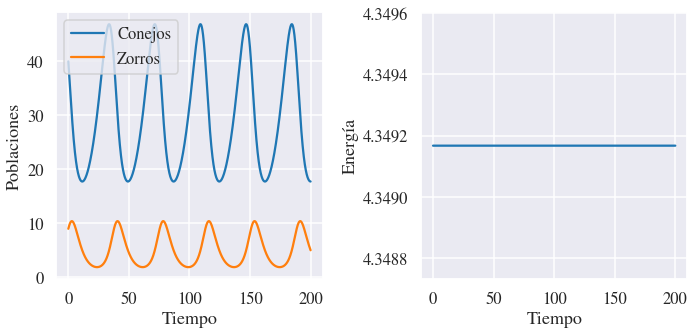

In [19]:
## Parámetros de integración
t0 = 0                        ## Tiempo inicial
tf = 200                      ## Tiempo final
h = 0.05                      ## Paso de integración
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)

## Definimos condicion inicial e integramos
y0 = (40, 9)
sol = solve_ivp(
    FoxesVsRabbits, t_span=t_span, y0=y0, 
    t_eval=t_eval, args=args, max_step=h
)

## Graficamos las soluciones
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(5*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
#ax.set_title('Poblaciones en función del tiempo')
ax.set_ylabel('Poblaciones')
ax.set_xlabel('Tiempo')
ax.plot(sol.t, sol.y[0], label='Conejos')
ax.plot(sol.t, sol.y[1], label='Zorros')
ax.legend()

ax = axes[1]
ax.set_ylim(energia(sol.y, *args)[0]*np.array([1-1e-4, 1+1e-4]))
#ax.set_title('Energía en función del tiempo')
ax.set_ylabel('Energía')
ax.set_xlabel('Tiempo')
ax.plot(sol.t, energia(sol.y, *args))

plt.tight_layout()

plt.savefig('evolucion_y_energia.pdf')
plt.show()

Podemos observar que ambas poblaciones oscilan de manera estable, en concordancia con la predicción teórica. Además, podemos ver que la población de presa presenta su pico antes que la población de depredadores, lo cual es esperable desde el punto de vista biológico. También podemos ver que la energía se conserva durante la integración, indicando que el método empleado (en este caso Runge-Kutta de orden 4), junto con el paso de integración elegido, no introducen un error numérico significativo durante el intervalo de integración.

**d)**

Realizamos el gráfico paramétrico en el plano de fases

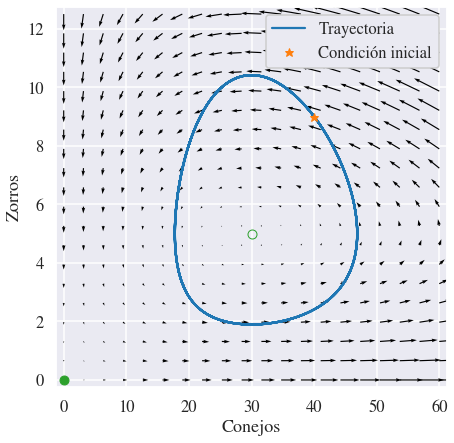

In [20]:
## Parámetros de integración
t0 = 0
tf = 200
h = 0.05
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)

## Resolvemos el sistema para distintas condiciones iniciales,
## para las cuales graficaremos las trayectorias
condiciones_iniciales = [
    (40, 9)
]
soluciones = []
for i, y0 in enumerate(condiciones_iniciales):
    sol = solve_ivp(FoxesVsRabbits, t_span=t_span, y0=y0, t_eval=t_eval, max_step=h, args=args)
    soluciones.append(sol)

## Creamos una grilla en el espacio de fases,
## representada por las variables R y S
c_values = np.linspace(0,2*gamma/delta,20)
z_values = np.linspace(0,2.5*alpha/beta,20)
C, Z = np.meshgrid(c_values, z_values)

## En cada punto de la grilla graficamos una flecha. Las variables
## U y V representan las coordenadas de las flechas 
U, V = FoxesVsRabbits(None, [C, Z], *args)

## Realizamos el gráfico
fig, ax = plt.subplots(figsize=(7,7))
ax.set_ylabel('Zorros')
ax.set_xlabel('Conejos')

## Graficamos el campo de pendientes
ax.quiver(C, Z, U, V)

## Punto fijo intestable
ax.plot(gamma/delta, alpha/beta, 'o', fillstyle='none', color=GREEN)

## Punto fijo estable
ax.plot(0, 0, 'o', color=GREEN)

## Graficamos trayectorias
for i, y0 in enumerate(condiciones_iniciales):
    sol = soluciones[i]
    ax.plot(sol.y[0], sol.y[1], color=BLUE, label='Trayectoria')

## Condiciones iniciales
for i, y0 in enumerate(condiciones_iniciales):
    ax.plot(*y0, '*', color=ORANGE, label='Condición inicial')
    
ax.margins(0.02)
#ax.legend(loc=(1.01, 0.9))
ax.legend(loc='upper right', framealpha=1)

plt.savefig('diagrama_de_fases.pdf')
plt.show()

Tal como mostramos analíticamente, las trayectorias en el espacio de fases son curvas cerradas.

Desde el punto de vista biológico, resulta interesante analizar el período de las oscilaciones. Para trayectorias que inician en valores cercanos al centro $P_2$, el período puede ser aproximado por $T_0 \simeq 2\pi / \omega$, donde $\omega = \sqrt{\alpha \gamma}$

In [7]:
def calcular_periodo(x, h=1):
    """
    Calcula el período de una señal oscilante como el promedio
    entre dos tiempos consecutivos en los cuales la señal pasa 
    de tener un valor por debajo de la media a un valor por 
    encima de la media.
    """
    x = np.array(x)
    x = x - x.mean()
    
    ## Cantiddad de pasos entre valores positivos
    pasos_entre_pos = np.diff(np.where(x>0)[0])
    
    distancias = np.diff(np.where(pasos_entre_pos>1)[0][::2]) * h
    per = distancias.mean()
    per_std = distancias.std()
    
    return per, per_std

In [8]:
## Parámetros de integración
h = 0.05
t0 = 0
tf = 1000
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)
n = t_eval.shape[0]

## Definimos condicion inicial e integramos
y0 = (40, 9)
sol = solve_ivp(FoxesVsRabbits, t_span=t_span, y0=y0, t_eval=t_eval, max_step=h, args=args)

In [9]:
per, per_std = calcular_periodo(sol.y[0], h=h)

T_0 = 2*np.pi/np.sqrt(alpha*gamma)
diff = (per - T_0) / T_0
print(f'T_0 = {T_0:.2f}')
print(f'Período de oscilación: {per:.2f} +- {per_std:.2f}')
print(f'Diferencia porcentual: {100*np.abs(diff):.1f}%')

T_0 = 36.28
Período de oscilación: 34.13 +- 0.04
Diferencia porcentual: 5.9%


Vemos que, para las condiciones iniciales elegidas, el período de oscilación difiere del valor aproximado teóricamente en aproximadamente un 6%.

In [25]:
## Parámetros de integración
h = 0.05
t0 = 0
tf = 200
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)
n = t_eval.shape[0]

## Definimos condicion inicial e integramos

c_values = np.arange(19.05, 49.05, 0.1)
initial_conditions = [(c, 5) for c in c_values]

In [10]:
solutions = []
for y0 in initial_conditions:
    print(y0)
    sol = solve_ivp(FoxesVsRabbits, t_span=t_span, y0=y0, t_eval=t_eval, max_step=h, args=args)
    solutions.append(sol)

(19.05, 5)
(19.150000000000002, 5)
(19.250000000000004, 5)
(19.350000000000005, 5)
(19.450000000000006, 5)
(19.550000000000008, 5)
(19.65000000000001, 5)
(19.75000000000001, 5)
(19.850000000000012, 5)
(19.950000000000014, 5)
(20.050000000000015, 5)
(20.150000000000016, 5)
(20.250000000000018, 5)
(20.35000000000002, 5)
(20.45000000000002, 5)
(20.550000000000022, 5)
(20.650000000000023, 5)
(20.750000000000025, 5)
(20.850000000000026, 5)
(20.950000000000028, 5)
(21.05000000000003, 5)
(21.15000000000003, 5)
(21.250000000000032, 5)
(21.350000000000033, 5)
(21.450000000000035, 5)
(21.550000000000036, 5)
(21.650000000000038, 5)
(21.75000000000004, 5)
(21.85000000000004, 5)
(21.950000000000042, 5)
(22.050000000000043, 5)
(22.150000000000045, 5)
(22.250000000000046, 5)
(22.350000000000048, 5)
(22.45000000000005, 5)
(22.55000000000005, 5)
(22.650000000000052, 5)
(22.750000000000053, 5)
(22.850000000000055, 5)
(22.950000000000056, 5)
(23.050000000000058, 5)
(23.15000000000006, 5)
(23.250000000000

In [ ]:
periodos = np.zeros((c_values.size, 2))
for i, c in enumerate(c_values):
    sol = solutions[i]
    per, per_std = calcular_periodo(sol.y[0], h=h)
    periodos[i] = [per, per_std]

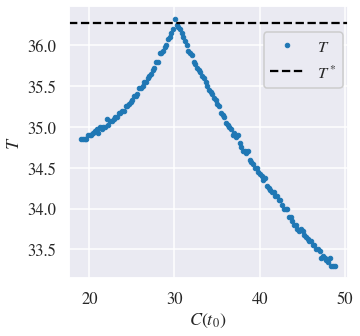

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlabel(r'$C(t_0)$')
ax.set_ylabel(r'$T$')
#ax.errorbar(c_values, periodos[:,0], periodos[:,1])
ax.plot(c_values[::2], periodos[:,0][::2],  '.', label=r'$T$')
ax.axhline(T_0, label=r'$T^*$', color='k', linestyle='--')

ax.legend(loc=(0.7,0.7), framealpha=1)

plt.savefig('periodo.pdf', bbox_inches='tight')
plt.show()